In [1]:
import pandas as pd

In [20]:
import importlib

import src.ingest_clean 
importlib.reload(src.ingest_clean)
from src.ingest_clean import *

import src.feature_engineering 
importlib.reload(src.feature_engineering)
from src.feature_engineering import *

import src.utils 
importlib.reload(src.utils)
from src.utils import *

import src.modeling 
importlib.reload(src.modeling)
from src.modeling import *

import src.eval_visuals 
importlib.reload(src.eval_visuals)
from src.eval_visuals import *

## Download and Clean Data

### Download data from DANE; five departaments : Antioquia, Córdoba, Chocó, Nariño, Cauca 

We focus on municipalities in Antioquia, Córdoba, Chocó, Nariño, and Cauca because they span Colombia’s two historical malaria macro-foci: the Pacific lowlands (Chocó, Nariño, Cauca), which account for roughly 50–60% of national cases, and the Urabá–Bajo Cauca–Alto Sinú corridor (Antioquia, Córdoba), contributing about 20–30%; Amazonia/Orinoquia contribute smaller shares. This targeting aligns with the Colombian Ministry of Health’s characterization of the country’s highest-burden regions and recent surveillance summaries. [Colombian Ministry of Health 2025](https://www.minsalud.gov.co/salud/publica/PET/Paginas/malaria.aspx)

In [ ]:
cnpv_fetch_per_hog_top5() # fetch the data from DANE webpage for the top 5 departaments with historical malaria issues
combine_cnpv_per_hog() # Combine the datasets fetched in the first step 

### Download malaria data and plot by departaments


Top 5 departments by cases:
department  cases
     CHOCO 297749
 ANTIOQUIA 236677
   NARIÃO 154261
   CORDOBA 126418
  GUAVIARE  35762


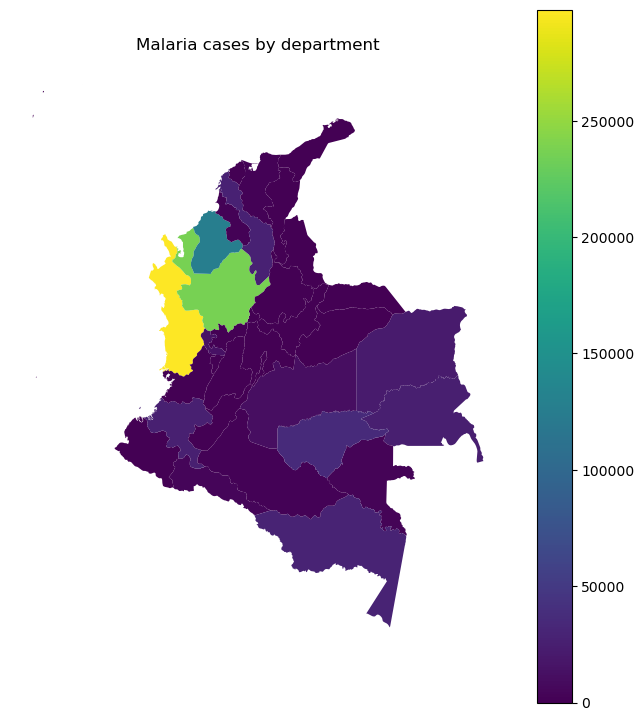

In [24]:
df_dep = agg_malaria_by_department()  # Fetched by week and municipality from https://www.datos.gov.co
plot_malaria_map_departments(df_dep, title="Malaria cases by department") # Plot malaria by departament (absolute numbers) 

### Download climate data

In [ ]:
# Set in True to download, it takes aproximately 30-40 min I recommend to use processed data instead. 
download_climate_(download_chirps=False, download_terraclimate=False)  # Set in False to download from repository. Set in True to download directly from databases, takes approximately 30~40 min in total to download and clean. 

[3/3] Done.


## Feature Engineering and EDA

### Malaria incidence weekly
Aggregates weekly malaria counts and computes indicators per total population.

Constructing output variables, relative malaria cases... 


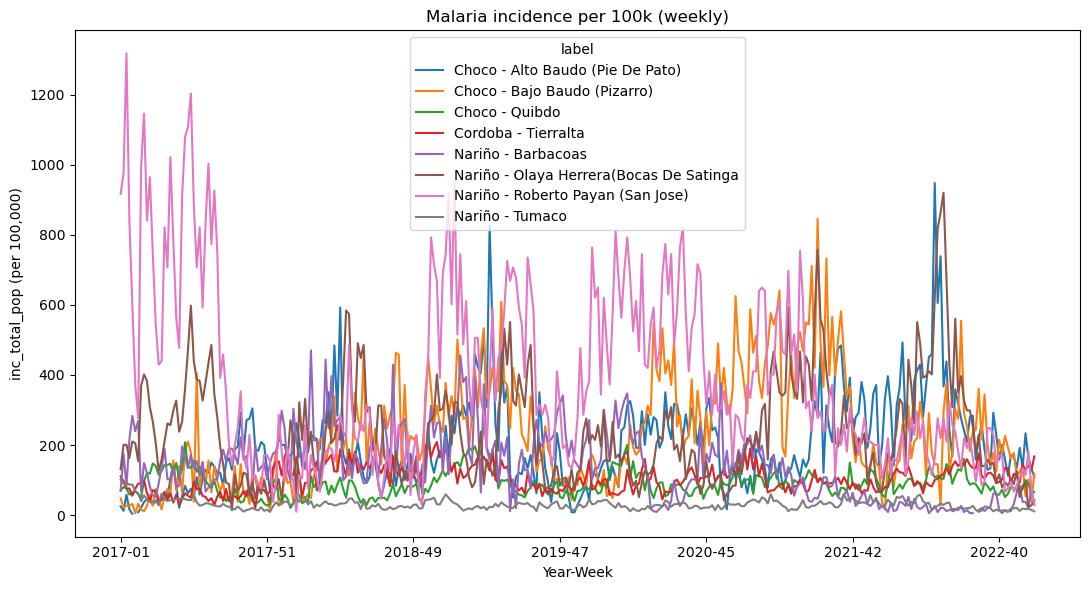

In [3]:
df_week = malaria_weekly_indicators(
    malaria_csv="data_raw/malaria_agg.csv",
    persons_csv="data_raw/cnper2018.csv",
    year_from=2017
)

### Malaria aggregated
 Aggregate malaria cases (2017–2022) by municipality and compute cumulative incidences using a fixed population (2018).

In [28]:
df_malaria_total = build_malaria_features_total(df_week)

Constructing output variables, total malaria cases... 


### Vulnerability index

We built the vulnerability index using data-driven weights so the data—not arbitrary choices—determine the relative importance of each epidemiologic rate. Concretely, we standardized municipality-level rates (e.g., total incidence, complicated cases, *P. vivax*, *P. falciparum*), ran a PCA on the correlation matrix, and used the (sign-adjusted) first-component loadings—rescaled to sum to 1—as indicator weights. This captures the common signal across correlated rates while preventing any single rate from dominating purely due to scale. We then stress-tested the index by comparing it to equal-weights and by bootstrap resampling to check the stability of weights and rankings. This follows OPHI’s guidance: treat weighting as a critical design choice, allow for data-driven (“statistical”) weights such as PCA, and run sensitivity/robustness analyses to alternative schemes. [Decancq & Lugo 2008](https://ophi.org.uk/sites/default/files/OPHI-wp18.pdf). 


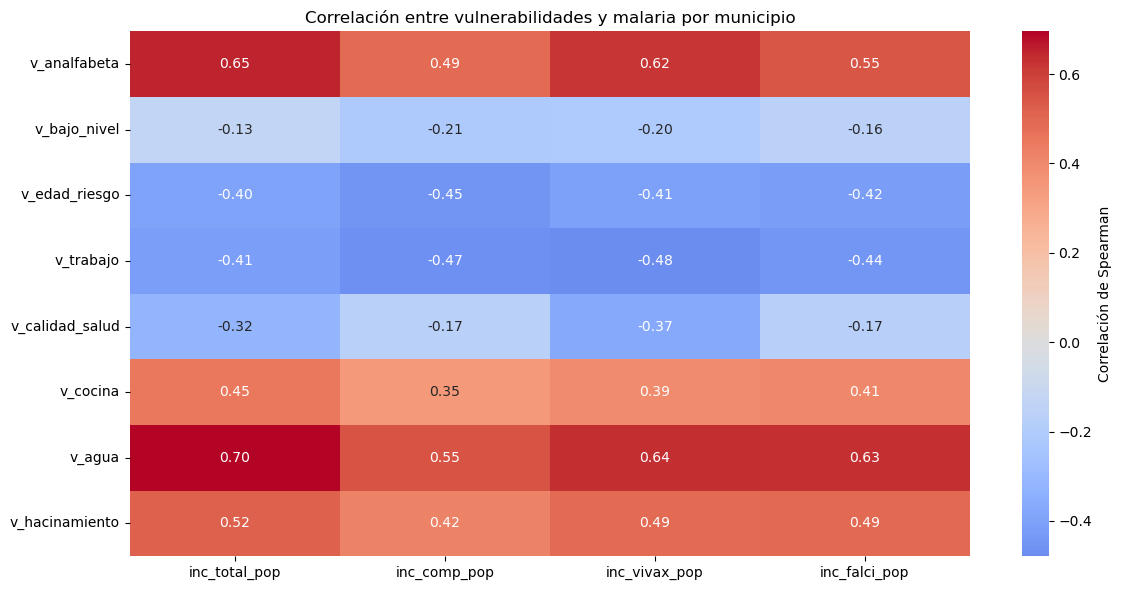

In [29]:
df_vuln_mpio = build_vulnerability_index( df_malaria_total)

### Maps
Produce side-by-side maps for vulnerability index, climate variables and malaria outcomes.

[*] Downloading GeoJSON from OpenDataSoft…
[*] Valid 5-digit mpio_code ratio: 100.0%
[✓] Saved: data_raw/colombia_mpios\colombia_mpios_opendatasoft.gpkg | data_raw/colombia_mpios\colombia_mpios_opendatasoft.shp


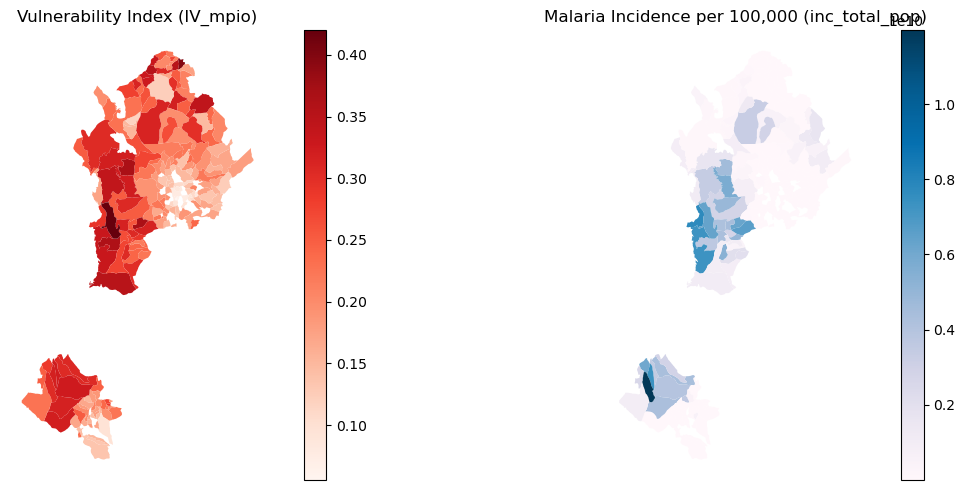

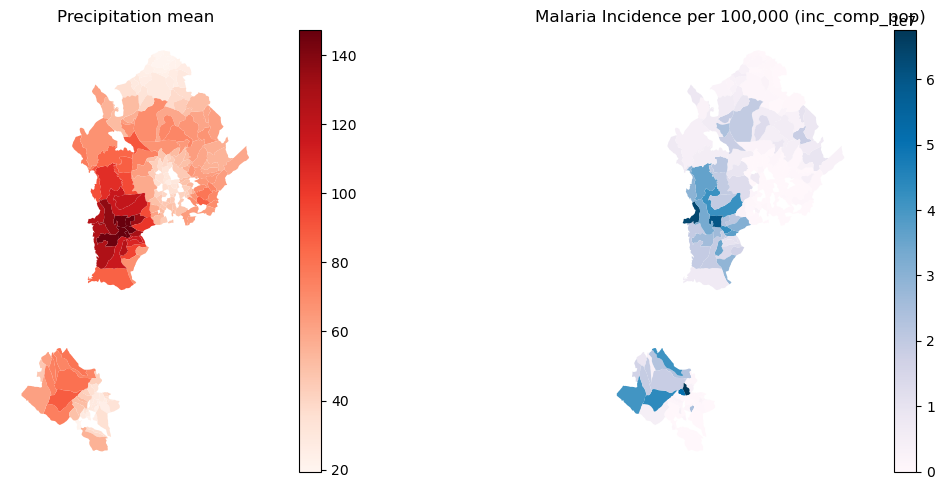

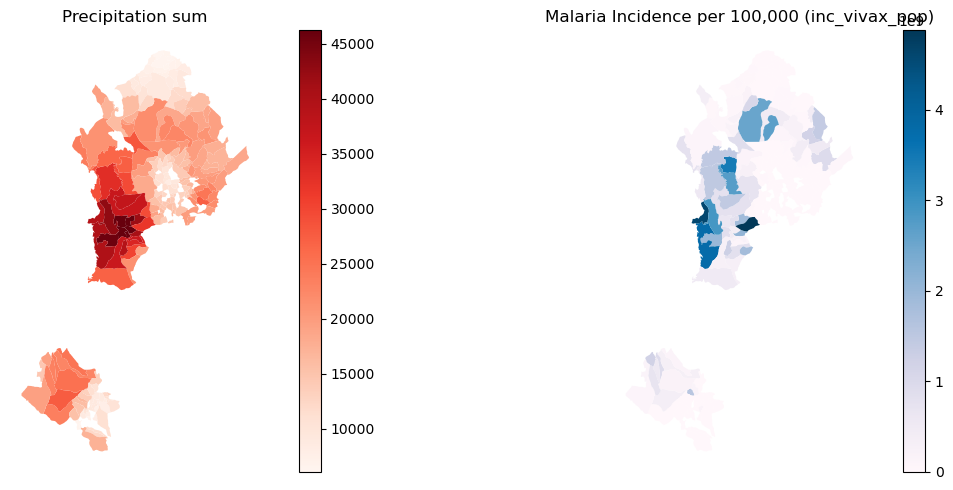

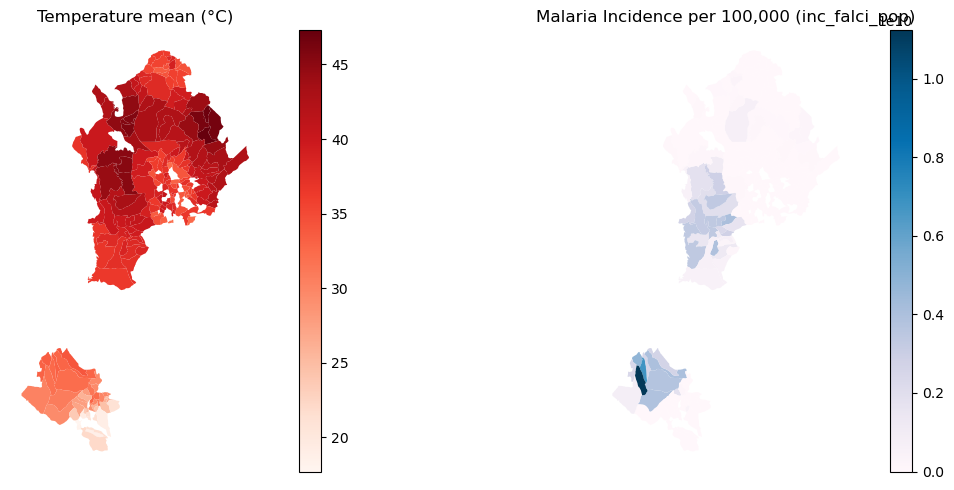

In [30]:
gdf_map = make_maps(df_vuln_mpio, df_malaria_total)

### Dispersion plots

Explanatory variables vs Outcomes

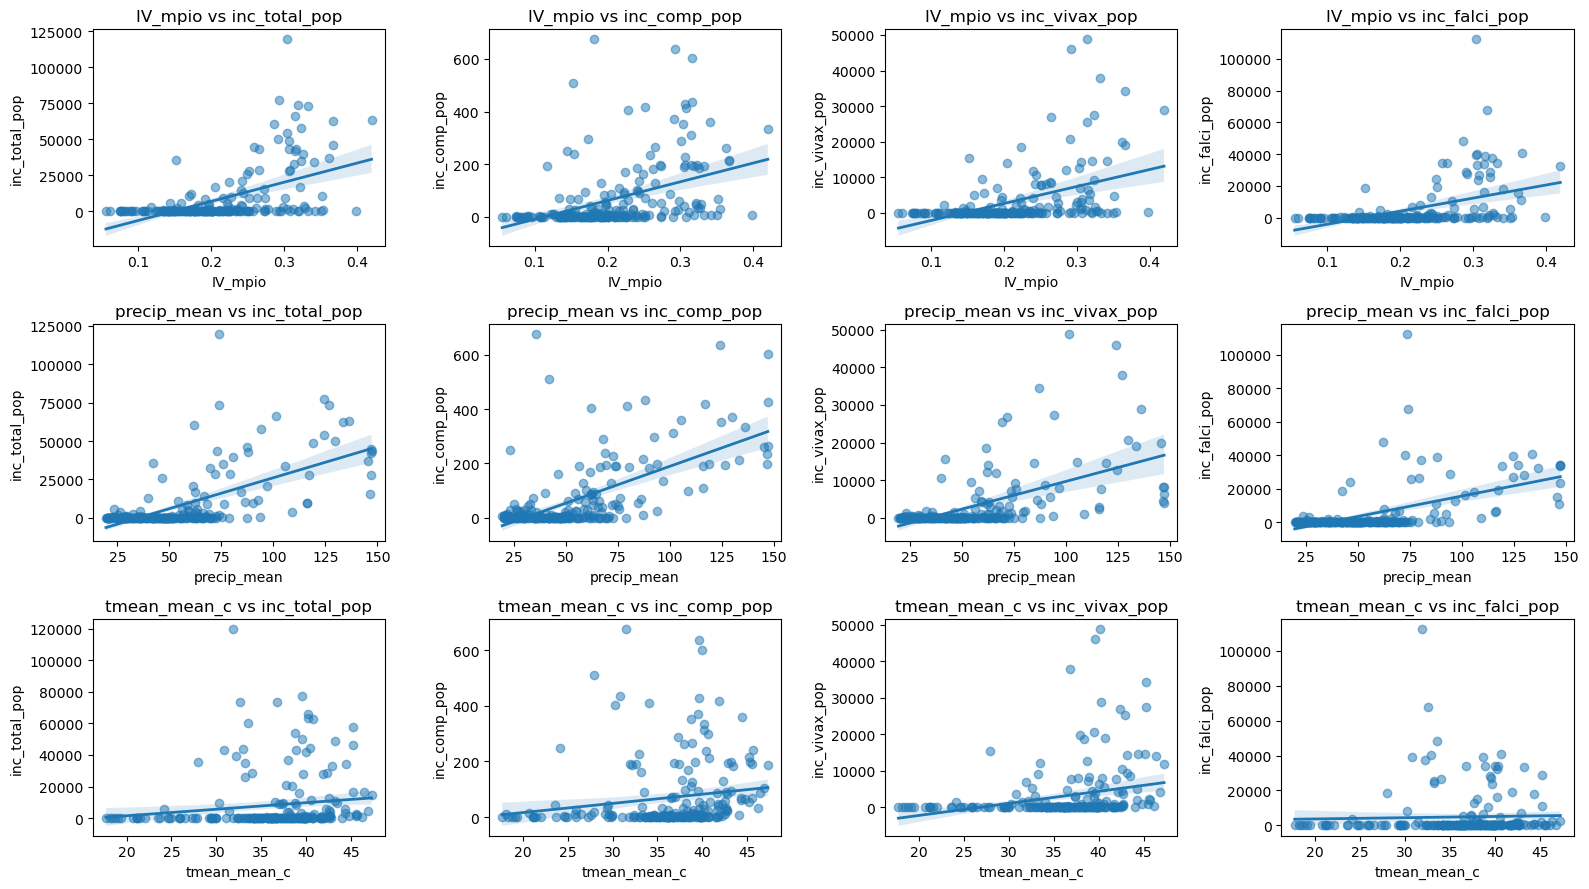

In [31]:
plot_iv_and_climate_vs_malaria(
    gdf_map,
    inc_vars=None,
    iv_col="IV_mpio",
    climate_vars=None,
    cell_size=(4, 3),
)

## Models

### Spatial Models
We built a spatial weights matrix using Queen contiguity, municipalities are neighbors if they share a boundary or a point. With that matrix we computed global spatial autocorrelation using Moran’s I with permutation based p-values, and local indicators of spatial association, LISA, to locate clusters. One municipality is an island with no contiguous neighbors, which is expected in administrative layers and is treated as not contributing to local statistics.

Moran’s I is a measure of spatial clustering, positive values indicate that similar values tend to be close in space, values near zero suggest randomness, and negative values indicate spatial dispersion. LISA decomposes the global pattern and classifies each municipality into high-high, low-low, high-low, or low-high, only when the local statistic is significant, otherwise it is labeled not significant.

The global results show strong spatial structure across all variables, n equals 210 throughout. Climate is the most spatially autocorrelated, mean temperature I equals 0.9045, p equals 0.001, and mean precipitation I equals 0.8839, p equals 0.001. The vulnerability index also clusters strongly, IV_mpio I equals 0.6032, p equals 0.001. Malaria indicators show clear clustering as well, total incidence I equals 0.6142 with p equals 0.001, falciparum incidence I equals 0.6464, p equals 0.001, complicated cases I equals 0.5335, p equals 0.001, and vivax incidence I equals 0.4122, p equals 0.001.

The LISA maps reveal where those patterns live on the ground. For total incidence we identify 26 high-high and 58 low-low clusters, with almost no spatial outliers, one low-high and zero high-low, and 125 not significant. Patterns are similar for falciparum and complicated cases, which again points to coherent hot spots and cold spots rather than isolated anomalies. Climate variables behave as broad fields, precipitation shows 26 high-high and 56 low-low with no outliers, and temperature shows 49 high-high and 37 low-low. The vulnerability index shows 36 high-high and 39 low-low clusters, with a small number of mixed clusters.

Taken together, these results confirm that malaria outcomes, climate covariates, and the vulnerability index are spatially clustered. For analysis this supports using spatial methods, for example models with spatial lags or spatial errors, or at minimum spatially robust standard errors. For decision making it suggests targeting clusters rather than individual municipalities, since transitions are gradual and true outliers are rare.

('WARNING: ', 99, ' is an island (no neighbors)')

=== Global Moran's I (per variable) ===
     variable       I     p_sim       z      EI      VI   n
      IV_mpio  0.6032  0.0010**  12.957 -0.0048  0.0022 210
 inc_comp_pop  0.5335  0.0010**  11.472 -0.0048  0.0022 210
inc_falci_pop  0.6464  0.0010**  13.878 -0.0048  0.0022 210
inc_total_pop  0.6142  0.0010**  13.192 -0.0048  0.0022 210
inc_vivax_pop  0.4122  0.0010**   8.887 -0.0048  0.0022 210
  precip_mean  0.8839  0.0010**  18.939 -0.0048  0.0022 210
 tmean_mean_c  0.9045  0.0010**  19.378 -0.0048  0.0022 210

Significance at α=0.05: * p<0.05, ** p<0.01, *** p<0.001

=== LISA cluster counts (masked by significance) ===
variable                    HH    LH    LL    HL     ns   total
---------------------------------------------------------------
inc_total_pop               28     2    52     0    128     210
inc_comp_pop                26     5    45     1    133     210
inc_vivax_pop               17     3    57     0    133     2

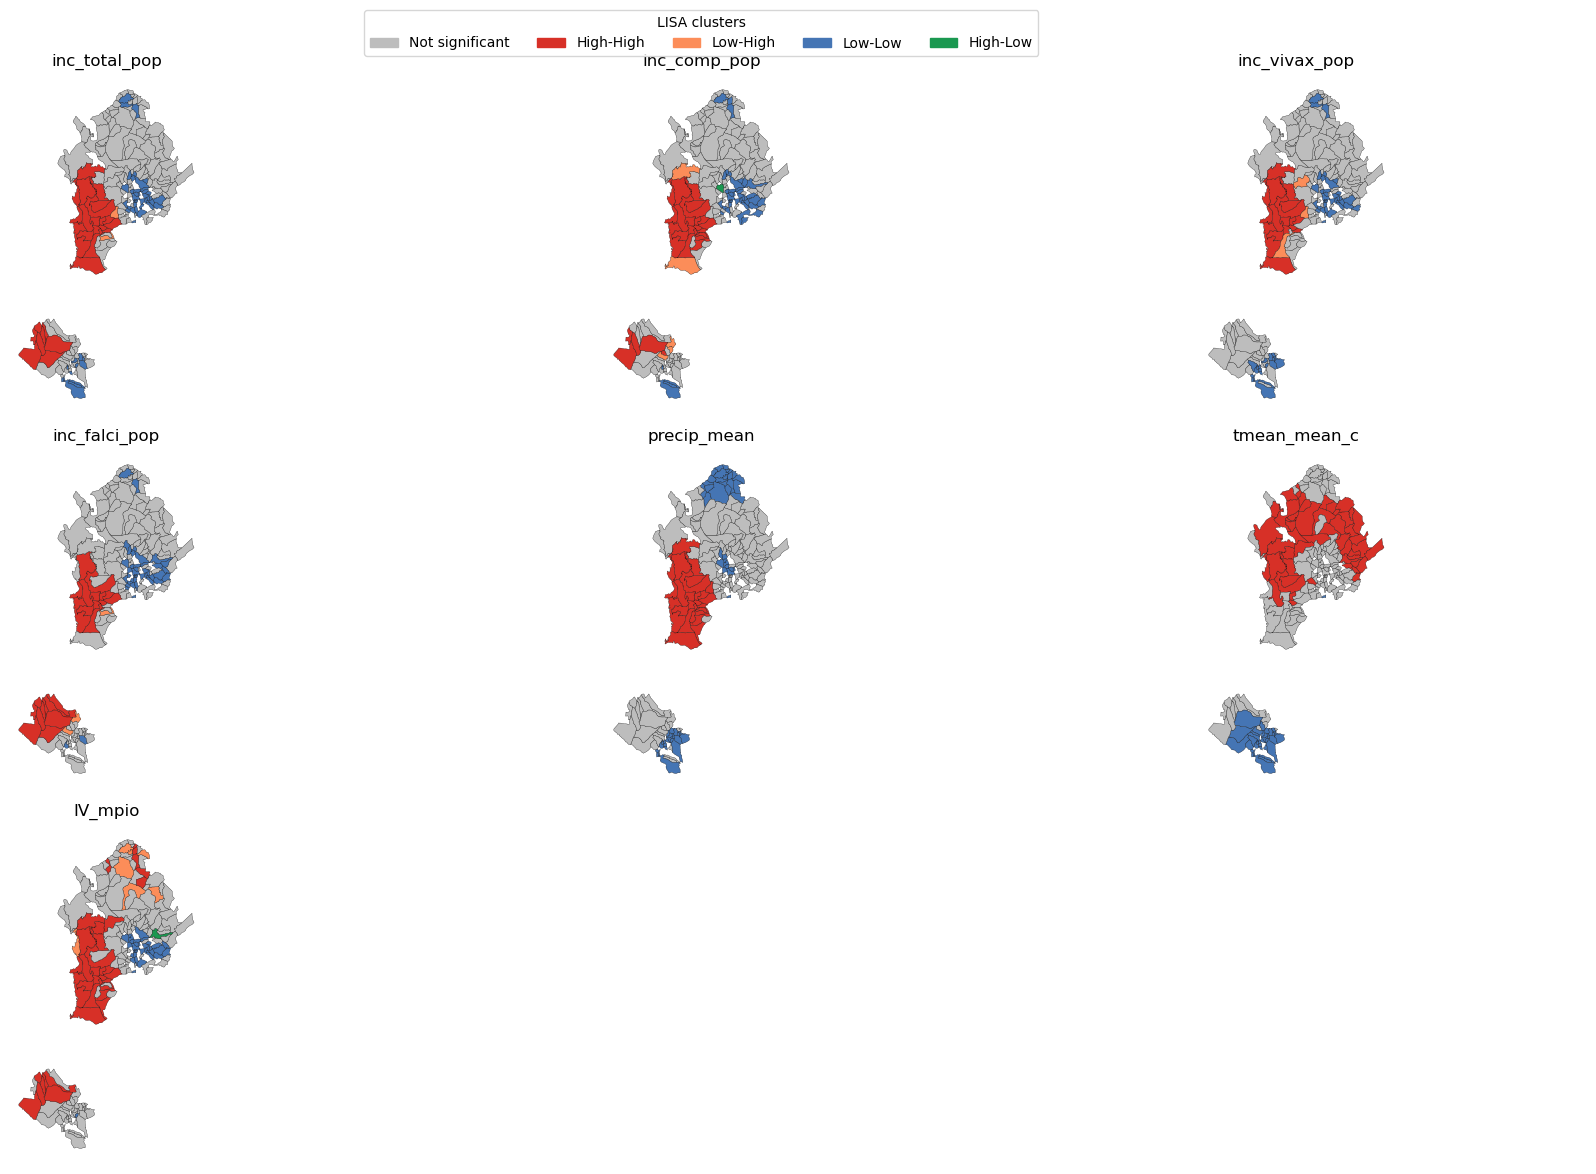

In [32]:
malaria_cols = ['inc_total_pop','inc_comp_pop','inc_vivax_pop','inc_falci_pop']
climate_cols = ['precip_mean', 'tmean_mean_c']  
vuln_col = 'IV_mpio'                     

# 2) Compute weights + Moran/LISA and augment gdf_map
gdf_map_lisa, moran_summary = compute_spatial_autocorr(
    gdf_map,
    malaria_cols=malaria_cols,
    climate_cols=climate_cols,
    vuln_col=vuln_col,
    weight_kind="Queen"  # or "Rook"
)
print_moran_summary(moran_summary, alpha=0.05)
vars_to_report = ['inc_total_pop','inc_comp_pop','inc_vivax_pop','inc_falci_pop','precip_mean','tmean_mean_c','IV_mpio']
print_lisa_cluster_counts(gdf_map_lisa, vars_to_report, p_threshold=0.05)

# 3) Plot grid (4 malaria + 2 climate + 1 vulnerability = 7 subplots)
vars_to_plot = malaria_cols + climate_cols + [vuln_col]
plot_lisa_grid(gdf_map_lisa, vars_to_plot, ncols=3, figsize=(18, 12), p_threshold=0.05)


### Spatial Durbin Model
We estimated a Spatial Durbin Model using a row-standardized Queen contiguity matrix, including a spatial lag of the outcome Wy and spatially lagged covariates WX. All predictors were annual z-scores, so coefficients can be read as changes in standard deviation units. One municipality has no contiguous neighbors, it is treated as an island and does not contribute to spillovers.

Across outcomes the model shows meaningful spatial dependence, with rho in the range of about 0.34 to 0.60 and pseudo R squared between about 0.46 and 0.66. Rainfall is the clearest signal: within-municipality effects are large and positive, for example about 0.63 for total incidence and about 0.83 for falciparum, while indirect WX terms are negative and often important, which leaves total effects that are positive but moderate. The vulnerability index matters as well, with positive direct effects for total and falciparum, a clear indirect effect for complicated cases, and a smaller but still positive total for vivax. Temperature is mixed and generally less precise, any positive direct contribution tends to be offset by negative spillovers from neighbors.

In practical terms, malaria risk clusters locally and is shaped by neighboring conditions, so models that ignore spatial dependence risk biased inference. Targeting should be organized by clusters rather than single municipalities, and it is sensible to check robustness with an alternative neighbor definition such as Rook or k-nearest neighbors and to confirm that results do not hinge on the island unit.

In [33]:

gdf_z = annualize_and_standardize(
    gdf_map,
    inc_cols=["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"],
    years=6,
    pred_cols=["IV_mpio","precip_mean","tmean_mean_c"]
)

# SDM for each outcome variable
for y_base in ["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"]:
    y_col  = f"{y_base}_ann_z"
    x_cols = ["IV_mpio_z","precip_mean_z","tmean_mean_c_z"]
    sdm, eff = fit_sdm_with_wx(gdf_z, y_col=y_col, x_cols=x_cols, weight_kind="Queen")
    print_sdm_effects_table(eff, title=f"SDM effects: {y_base} (annual, z)")


('WARNING: ', 99, ' is an island (no neighbors)')

=== SDM effects: inc_total_pop (annual, z) ===
n=210  |  pseudo R²=0.655
rho (W*y) = 0.5350
      variable  direct p_direct indirect_WX p_indirect total(direct+indirect)
     IV_mpio_z  0.2224   0.0004     -0.0492     0.5595                 0.1732
 precip_mean_z  0.6276   0.0003     -0.3644     0.0629                 0.2632
tmean_mean_c_z  0.1419   0.3729     -0.2316     0.1736                -0.0898
('WARNING: ', 99, ' is an island (no neighbors)')

=== SDM effects: inc_comp_pop (annual, z) ===
n=210  |  pseudo R²=0.534
rho (W*y) = 0.3386
      variable  direct p_direct indirect_WX p_indirect total(direct+indirect)
     IV_mpio_z -0.0013   0.9862      0.2207     0.0212                 0.2194
 precip_mean_z  0.2944   0.1457      0.1093     0.6333                 0.4036
tmean_mean_c_z  0.3718   0.0442     -0.4876     0.0134                -0.1157
('WARNING: ', 99, ' is an island (no neighbors)')

=== SDM effects: inc_vivax_pop (annual, 

### Time Series Modeling

In [34]:
df_time = build_time_series_df(df_week)

[INFO] % non merged rows: 0.95%



#### Model

For each municipality we estimate a weekly distributed-lag regression of malaria incidence on precipitation at lags 0–4:

y_t = alpha + beta_0rain_{t} + beta_1rain_{t-1} + beta_2rain_{t-2} + beta_3rain_{t-3} + beta_4*rain_{t-4} + error_t

We fit by ordinary least squares and use Newey–West (HAC) standard errors to handle autocorrelation and heteroskedasticity in the weekly series. To avoid diluting the signal with dry-season weeks, the sample is restricted to a “rainy window”: weeks in months whose total precipitation exceeds a small threshold, plus a 4-week carryover so short lags are retained.

#### Effect measure

The main quantity we report is the cumulative rainfall effect over the 0–4 week window:

beta_cum = beta_0 + beta_1 + beta_2 + beta_3 + beta_4

Its standard error comes from the delta method using the full covariance among the five lag coefficients. beta_cum summarizes the short-run association between this week’s incidence and cumulative rain over the prior five weeks (current week included).

#### Reading the results table

For each municipality the table shows: number of usable weeks (n_obs), the five lag coefficients beta_0…beta_4 with their standard errors, the cumulative effect beta_cum with its standard error, the corresponding z and p values, and a simple label:

pos_sig means beta_cum > 0 with p < alpha

neg_sig means beta_cum < 0 with p < alpha

ns means not significant

#### How to interpret magnitudes

Pick a plausible rainfall change over the 0–4 week window, say ΔRain_{0:4} millimeters. The expected change in the outcome is approximately:

Δy ≈ beta_cum * ΔRain_{0:4}

If the outcome is an incidence per person, multiply by 100,000 to express the change per 100,000 population:

Δy_per_100k ≈ 100,000 * beta_cum * ΔRain_{0:4}

Example: if beta_cum = 1.15e-05 and the 0–4 week cumulative rainfall is 10 mm higher, then Δy_per_100k ≈ 100,000 * 1.15e-05 * 10 ≈ 11.5.


[INFO] Kept weeks under rainy-window (K=4): 99.7%


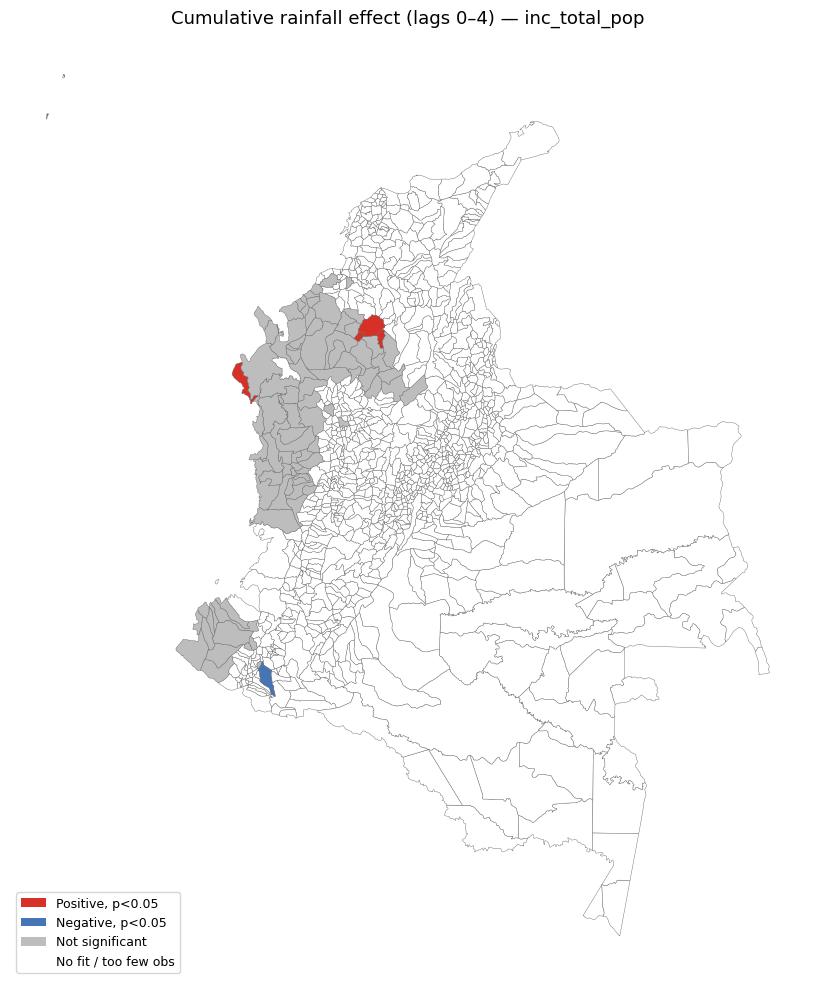

,mpio_code,n_obs,status,cum_effect,cum_se,cum_z,cum_p,beta_0,se_0,beta_1,se_1,beta_2,se_2,beta_3,se_3,beta_4,se_4,class
0,52001,32,ok,-2.445375e-08,1.073075e-08,-2.278848,0.022676,-1.799509e-08,7.540783e-09,-7.540977e-09,5.891642e-09,-6.558012e-09,3.495574e-09,5.530872e-09,4.155593e-09,2.109457e-09,4.086521e-09,neg_sig
1,27372,87,ok,1.146151e-05,2.716247e-06,4.219612,0.000024,5.891255e-07,1.599420e-06,5.148509e-06,1.840700e-06,4.632169e-07,1.183324e-06,1.858993e-06,1.136510e-06,3.401665e-06,1.611197e-06,pos_sig
2,23350,36,ok,5.354170e-07,1.968273e-07,2.720237,0.006524,3.361952e-07,1.338906e-07,-4.624972e-08,1.138475e-07,2.347585e-07,9.088418e-08,-9.287813e-08,1.127271e-07,1.035911e-07,8.310152e-08,pos_sig
3,05495,276,ok,6.082290e-07,2.926201e-07,2.078562,0.037658,4.018850e-07,2.140091e-07,1.597043e-07,1.686690e-07,2.509904e-07,1.744768e-07,-1.997571e-08,1.786200e-07,-1.843750e-07,2.024494e-07,pos_sig
4,23068,50,ok,6.505034e-08,3.176017e-08,2.048173,0.040543,3.853195e-08,1.576231e-08,4.156295e-08,3.891719e-08,-2.559871e-08,4.283557e-08,8.943881e-09,4.608462e-08,1.610271e-09,2.697850e-08,pos_sig


mpio_code  n_obs status    cum_effect       cum_se     cum_z    cum_p        beta_0         se_0        beta_1         se_1        beta_2         se_2        beta_3         se_3        beta_4         se_4   class
    52001     32     ok -2.445375e-08 1.073075e-08 -2.278848 0.022676 -1.799509e-08 7.540783e-09 -7.540977e-09 5.891642e-09 -6.558012e-09 3.495574e-09  5.530872e-09 4.155593e-09  2.109457e-09 4.086521e-09 neg_sig
    27372     87     ok  1.146151e-05 2.716247e-06  4.219612 0.000024  5.891255e-07 1.599420e-06  5.148509e-06 1.840700e-06  4.632169e-07 1.183324e-06  1.858993e-06 1.136510e-06  3.401665e-06 1.611197e-06 pos_sig
    23350     36     ok  5.354170e-07 1.968273e-07  2.720237 0.006524  3.361952e-07 1.338906e-07 -4.624972e-08 1.138475e-07  2.347585e-07 9.088418e-08 -9.287813e-08 1.127271e-07  1.035911e-07 8.310152e-08 pos_sig
    05495    276     ok  6.082290e-07 2.926201e-07  2.078562 0.037658  4.018850e-07 2.140091e-07  1.597043e-07 1.686690e-07  2.509904e-07 1.744768e-

In [35]:
results, keep_rate, fig, ax = run_rainy_window_pipeline_with_map(
    df_time=df_time,
    outcomes=["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"],
    shapes_path="data_raw/colombia_mpios/colombia_mpios_opendatasoft.shp",
    month_threshold_mm=5.0,
    K=4,
    hac_maxlags=8,
    min_obs=30,
    alpha=0.05,
    map_outcome="inc_total_pop",
    verbose=True
)

alpha_sig = 0.05
from IPython.display import display

tbl_full = results["inc_total_pop"].copy()

# Filter to significant only (based on the precomputed 'class' label)
sig_mask = (tbl_full["status"].eq("ok")) & (tbl_full["class"].isin(["pos_sig", "neg_sig"]))
tbl_sig = (
    tbl_full.loc[sig_mask]
            .sort_values(["class", "cum_p", "cum_effect"])
            .reset_index(drop=True)
)

# Pretty display in notebooks (only significant rows)
display(tbl_sig)

# Console print (text-only) — only significant rows
print(tbl_sig.to_string(index=False))

# Save to CSV — only significant rows
tbl_full.to_csv("outputs/tables/per_mpio_linear_inc_total_pop_rainywin.csv", index=False)


